In [2]:
import torch
import torchoptics
from torchoptics import Field, System
from torchoptics.elements import Lens
from torchoptics.profiles import checkerboard

In [3]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

devNumber = torch.cuda.current_device()
print(f"The current device number is {devNumber}")

dev_name = torch.cuda.get_device_name(devNumber)
print(f"GPU is {dev_name}")

# Create a tensor on the CPU
T1 = torch.randn(4,4)
print("CPU Tensor:")
print(T1)

# Convert tensor to GPU (CUDA Tensor)
T2 = T1.to(device)
print("GPU Tensor:")
print(T2)

Using Device: cuda
The current device number is 0
GPU is NVIDIA GeForce RTX 2060
CPU Tensor:
tensor([[ 0.1301,  0.9181, -0.2604, -1.1535],
        [-0.7359,  0.6105, -0.4805, -1.3353],
        [-0.8351,  1.4059,  0.5933, -0.0314],
        [ 0.7558,  0.2194,  0.3272, -0.9434]])
GPU Tensor:
tensor([[ 0.1301,  0.9181, -0.2604, -1.1535],
        [-0.7359,  0.6105, -0.4805, -1.3353],
        [-0.8351,  1.4059,  0.5933, -0.0314],
        [ 0.7558,  0.2194,  0.3272, -0.9434]], device='cuda:0')


Device: cuda


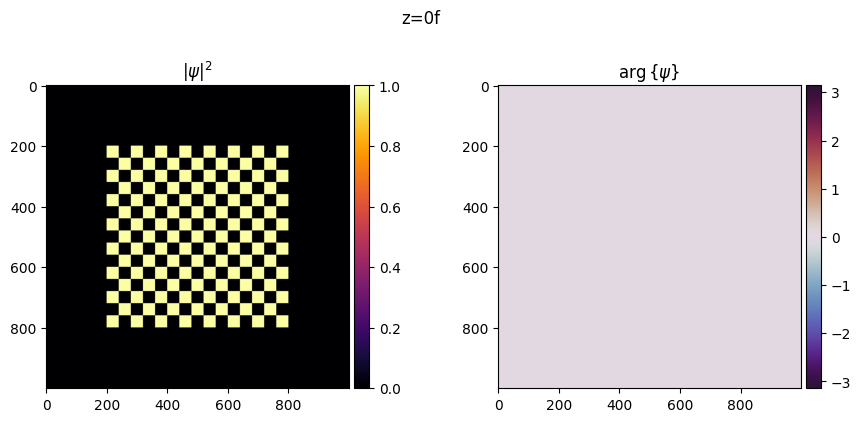

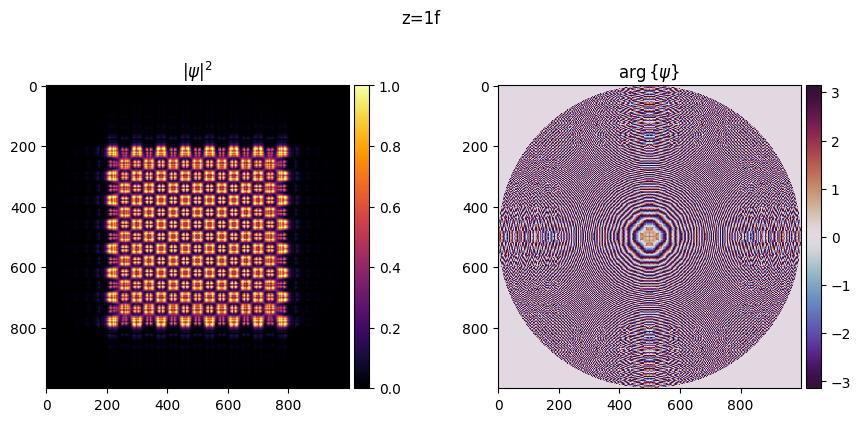

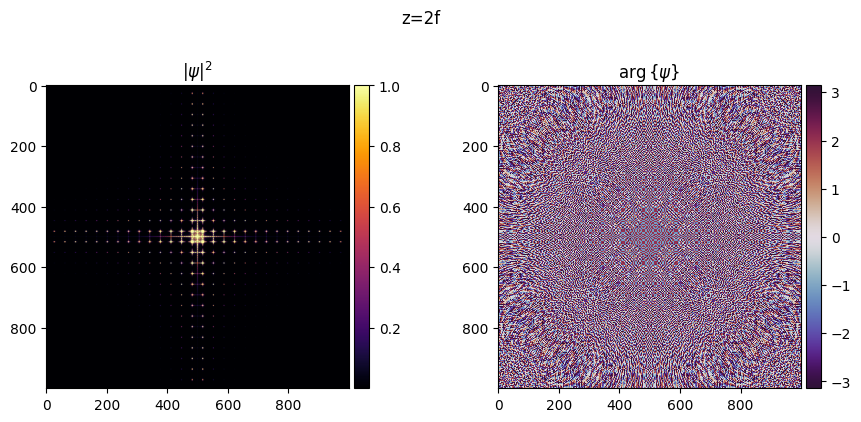

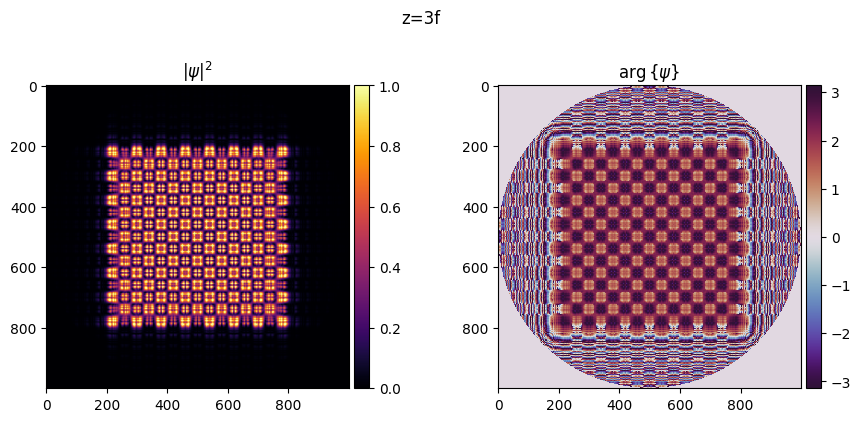

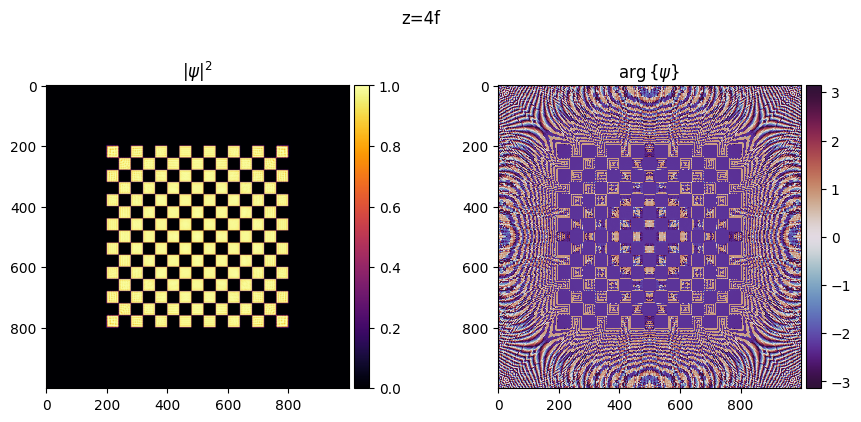

In [4]:
# Set simulation properties
shape = 1000  # Number of grid points in each dimension
spacing = 10e-6  # Spacing between grid points (m)
wavelength = 700e-9  # Field wavelength (m)
focal_length = 200e-3  # Lens focal length (m)
tile_length = 400e-6  # Checkerboard tile length (m)
num_tiles = 15  # Number of tiles in each dimension

# Determine device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# Configure torchoptics default properties
torchoptics.set_default_spacing(spacing)
torchoptics.set_default_wavelength(wavelength)

# Initialize input field with checkerboard pattern
field_data = checkerboard(shape, tile_length, num_tiles)
input_field = Field(field_data).to(device)

# Define 4f optical system with two lenses
system = System(
    Lens(shape, focal_length, z=1 * focal_length),
    Lens(shape, focal_length, z=3 * focal_length),
).to(device)

# Measure field at focal planes along the z-axis
measurements = [
    system.measure_at_z(input_field, z=i * focal_length)
    for i in range(5)
]

# Visualize the measured intensity distributions
for i, measurement in enumerate(measurements):
    measurement.visualize(title=f"z={i}f", vmax=1)

In [19]:
measurement

Field(shape=(1000, 1000), z=8.00e-01, spacing=(1.00e-05, 1.00e-05), offset=(0.00e+00, 0.00e+00), wavelength=7.00e-07, propagation_method=AUTO, asm_pad_factor=(2, 2), interpolation_mode=bilinear))

### Testing the code from the PyTorch Introduction Paper:
https://universityofexeteruk-my.sharepoint.com/:b:/g/personal/d_phillips_exeter_ac_uk/EQodqXfeoK9Mn5xkWWPmypoBJU4lqpfT35xgOUKccSIapg?e=wSFUXF

In [5]:
from torchoptics import Field, Param, System
from torchoptics.elements import PhaseModulator
from torchoptics.profiles import gaussian

# Set simulation properties
shape = 250 # Number of grid points in each dimension
waist_radius = 150e-6 # Waist radius of the Gaussian beam (m)
spacing = 10e-6 # Spacing between grid points (m)
wavelength = 700e-9 # Wavelength of the light (m)

# Determine device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Configure torchoptics default properties
torchoptics.set_default_spacing(spacing)
torchoptics.set_default_wavelength(wavelength)

# Initialize input and target fields
input_field = Field(gaussian(shape, waist_radius), z=0).to(device)
target_field = Field(torch.load("target.pt"), z=0.6).to(device)

# Define optical system with three trainable phase modulators
elements = [
    PhaseModulator(Param(torch.zeros(shape, shape)), z)
    for z in [0.0, 0.2, 0.4]
]
system = System(*elements).to(device)

# Train system to match the output and target fields
optimizer = torch.optim.Adam(system.parameters(), lr=0.1)
for iteration in range(400):
    optimizer.zero_grad()
    output_field = system.measure_at_z(input_field, 0.6)
    loss = 1 - output_field.inner(target_field).abs().square()
    loss.backward()
    optimizer.step()

C:\Users\elija\AppData\Local\Temp\ipykernel_6236\1697924635.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  target_field = Field(torch.load("target.pt"), z=0.6).to(devi

FileNotFoundError: [Errno 2] No such file or directory: 'target.pt'

In [7]:
from torchoptics import PolarizedField
from torchoptics.elements import LinearPolarizer
# Set simulation properties
shape = 1000
torchoptics.set_default_spacing(10e-6)
torchoptics.set_default_wavelength(700e-9)
# Initialize polarized field
field_data = torch.zeros(3, shape, shape)
field_data[0] = 1 # Polarized along x-axis
field = PolarizedField(field_data).normalize()
# Initialize linear polarizers
polarizer_45 = LinearPolarizer(shape, theta=torch.pi / 4)
polarizer_90 = LinearPolarizer(shape, theta=torch.pi / 2)
# Print the total power after transformations
print(field.power()) # 1
print(polarizer_45(field).power()) # 0.5
print(polarizer_90(field).power()) # 0
print(polarizer_90(polarizer_45(field)).power()) # 0.25

tensor(1., dtype=torch.float64)
tensor(0.5000, dtype=torch.float64)
tensor(3.7494e-33, dtype=torch.float64)
tensor(0.2500, dtype=torch.float64)


In [48]:
from torchoptics import CoherenceField
from torchoptics.profiles import gaussian_schell_model
# Set simulation properties
shape = 50
waist_radius = 50e-6 # Field waist radius
coherence_width = 25e-6 # Spatial coherence width
torchoptics.set_default_spacing(10e-6)
torchoptics.set_default_wavelength(700e-9)
# Initialize field spatial coherence with Gaussian Schell model
data = gaussian_schell_model(shape, waist_radius, coherence_width)
coherence_field = CoherenceField(data).to(device)
# Propagate the coherence field to different planes along z-axis
propagated_coherence_fields = [
    coherence_field.propagate_to_z(z)
    for z in [0, 0.02, 0.04]
]

#propagated_coherence_fields.visualize(title=f"z={i}f", vmax=1)
propagated_coherence_fields

[CoherenceField(shape=(50, 50), z=0.00e+00, spacing=(1.00e-05, 1.00e-05), offset=(0.00e+00, 0.00e+00), wavelength=7.00e-07, propagation_method=AUTO, asm_pad_factor=(2, 2), interpolation_mode=bilinear)),
 CoherenceField(shape=(50, 50), z=2.00e-02, spacing=(1.00e-05, 1.00e-05), offset=(0.00e+00, 0.00e+00), wavelength=7.00e-07, propagation_method=AUTO, asm_pad_factor=(2, 2), interpolation_mode=bilinear)),
 CoherenceField(shape=(50, 50), z=4.00e-02, spacing=(1.00e-05, 1.00e-05), offset=(0.00e+00, 0.00e+00), wavelength=7.00e-07, propagation_method=AUTO, asm_pad_factor=(2, 2), interpolation_mode=bilinear))]

In [8]:
from torchoptics.profiles import gaussian
gaussian(10, 150e-6)

tensor([[4442.9947+0.j, 4603.8099+0.j, 4728.2297+0.j, 4813.0387+0.j, 4856.0120+0.j,
         4856.0120+0.j, 4813.0387+0.j, 4728.2297+0.j, 4603.8099+0.j, 4442.9947+0.j],
        [4603.8099+0.j, 4770.4457+0.j, 4899.3690+0.j, 4987.2477+0.j, 5031.7764+0.j,
         5031.7764+0.j, 4987.2477+0.j, 4899.3690+0.j, 4770.4457+0.j, 4603.8099+0.j],
        [4728.2297+0.j, 4899.3690+0.j, 5031.7764+0.j, 5122.0301+0.j, 5167.7622+0.j,
         5167.7622+0.j, 5122.0301+0.j, 5031.7764+0.j, 4899.3690+0.j, 4728.2297+0.j],
        [4813.0387+0.j, 4987.2477+0.j, 5122.0301+0.j, 5213.9026+0.j, 5260.4550+0.j,
         5260.4550+0.j, 5213.9026+0.j, 5122.0301+0.j, 4987.2477+0.j, 4813.0387+0.j],
        [4856.0120+0.j, 5031.7764+0.j, 5167.7622+0.j, 5260.4550+0.j, 5307.4230+0.j,
         5307.4230+0.j, 5260.4550+0.j, 5167.7622+0.j, 5031.7764+0.j, 4856.0120+0.j],
        [4856.0120+0.j, 5031.7764+0.j, 5167.7622+0.j, 5260.4550+0.j, 5307.4230+0.j,
         5307.4230+0.j, 5260.4550+0.j, 5167.7622+0.j, 5031.7764+0.j, 48

In [27]:
from torchoptics import CoherenceField
from torchoptics.profiles import gaussian_schell_model as gsm

In [28]:
# Set simulation properties
shape = 50  # Number of grid points in each dimension
spacing = 10e-6  # Spacing between grid points (m)
wavelength = 700e-9  # Field wavelength (m)
waist_radius = 50e-6  # Waist radius of the Gaussian beam (m)
high_coherence_width = 1e-3  # Coherence width of the field with high coherence (m)
low_coherence_width = 10e-6  # Coherence width of the field with low coherence (m)

# Determine device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Configure torchoptics default properties
torchoptics.set_default_spacing(spacing)
torchoptics.set_default_wavelength(wavelength)

In [29]:
high_coherence_field = CoherenceField(gsm(shape, waist_radius, high_coherence_width)).to(device)
low_coherence_field = CoherenceField(gsm(shape, waist_radius, low_coherence_width)).to(device)

In [30]:
propagation_distances = [0, 0.01, 0.02]

for z in propagation_distances:
    high_coherence_field.propagate_to_z(z).visualize(title=f"Field with high coherence at z = {z} m")

for z in propagation_distances:
    low_coherence_field.propagate_to_z(z).visualize(title=f"Field with low coherence at z = {z} m")

ValueError: Expected tensor to be 2D, but got shape torch.Size([50, 50, 50, 50]).

### Training a diffractive beam splitter
Code from Torch Optics Tutorials

In [31]:
import torch
import torchoptics
import matplotlib.pyplot as plt

from torchoptics import Field, System, Param
from torchoptics.elements import PhaseModulator
from torchoptics.profiles import gaussian

In [32]:
shape = 250
waist_radius = 150e-6
device = "cuda" if torch.cuda.is_available() else "cpu"

torchoptics.set_default_spacing(10e-6)
torchoptics.set_default_wavelength(700e-9)

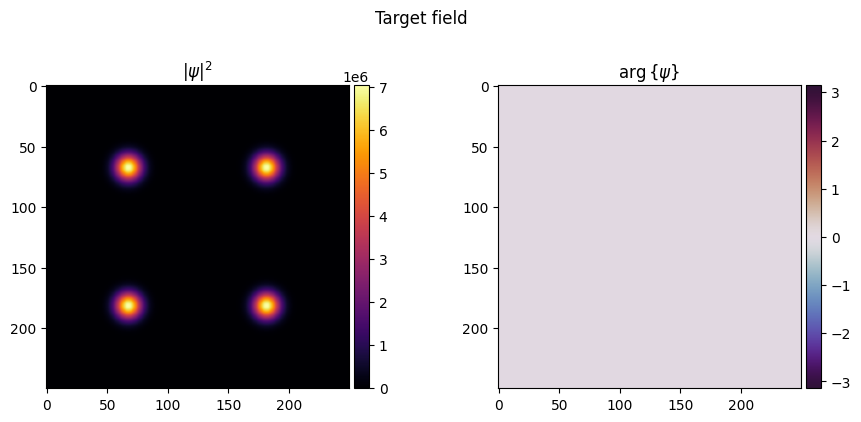

In [33]:
target_field_data = (
    gaussian(shape, waist_radius, offset=(3.8 * waist_radius, 3.8 * waist_radius))
    + gaussian(shape, waist_radius, offset=(3.8 * waist_radius, -3.8 * waist_radius))
    + gaussian(shape, waist_radius, offset=(-3.8 * waist_radius, 3.8 * waist_radius))
    + gaussian(shape, waist_radius, offset=(-3.8 * waist_radius, -3.8 * waist_radius))
) / 2
target_field = Field(target_field_data, z=0.6).to(device)

target_field.visualize(title="Target field")

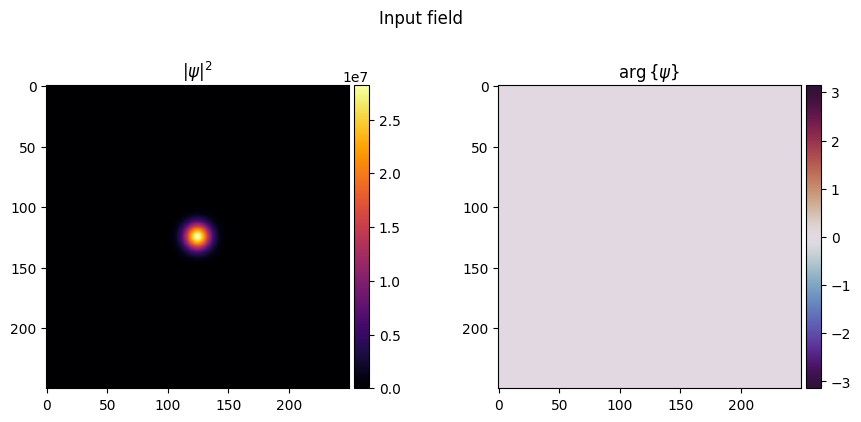

In [34]:
input_field = Field(gaussian(shape, waist_radius), z=0).to(device)
input_field.visualize(title="Input field")

In [35]:
system = System(
    PhaseModulator(Param(torch.zeros(shape, shape)), z=0.0),
    PhaseModulator(Param(torch.zeros(shape, shape)), z=0.2),
    PhaseModulator(Param(torch.zeros(shape, shape)), z=0.4),
).to(device)

In [36]:
optimizer = torch.optim.Adam(system.parameters(), lr=0.1)
losses = []
for iteration in range(400):
    optimizer.zero_grad()
    output_field = system.measure_at_z(input_field, 0.6)
    loss = 1 - output_field.inner(target_field).abs().square()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if iteration % 10 == 0:
        print(f"Iteration {iteration}, Loss {loss.item()}")

Iteration 0, Loss 0.9784589364196276
Iteration 10, Loss 0.5717267585641479
Iteration 20, Loss 0.2815336160351125
Iteration 30, Loss 0.13190796933594506
Iteration 40, Loss 0.0775423947467282
Iteration 50, Loss 0.051543123503625554
Iteration 60, Loss 0.03715064886167874
Iteration 70, Loss 0.02834961446981965
Iteration 80, Loss 0.021785695486636114
Iteration 90, Loss 0.016057424143396504
Iteration 100, Loss 0.011977746351006013
Iteration 110, Loss 0.009444077022195296
Iteration 120, Loss 0.00808440249293052
Iteration 130, Loss 0.007148053046840852
Iteration 140, Loss 0.006397778150567857
Iteration 150, Loss 0.0057325584993777046
Iteration 160, Loss 0.0051366237632270995
Iteration 170, Loss 0.004607192740766153
Iteration 180, Loss 0.00414237663342254
Iteration 190, Loss 0.0037900176139067376
Iteration 200, Loss 0.0035216642050931446
Iteration 210, Loss 0.0033207161628832083
Iteration 220, Loss 0.003161446350073094
Iteration 230, Loss 0.003049540255579908
Iteration 240, Loss 0.0029729383218

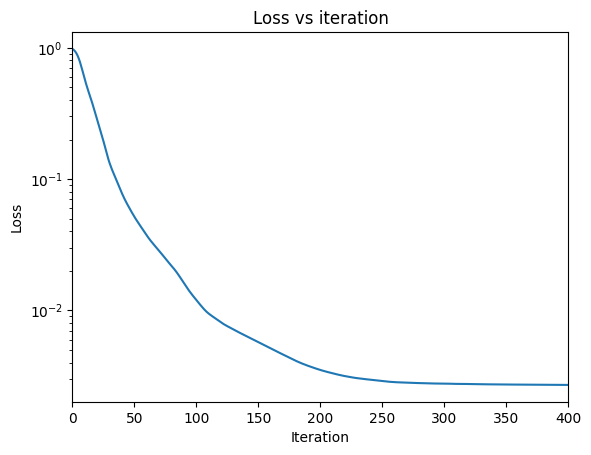

In [37]:
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss vs iteration")
plt.yscale("log")
plt.xlim(0, len(losses))
plt.show()

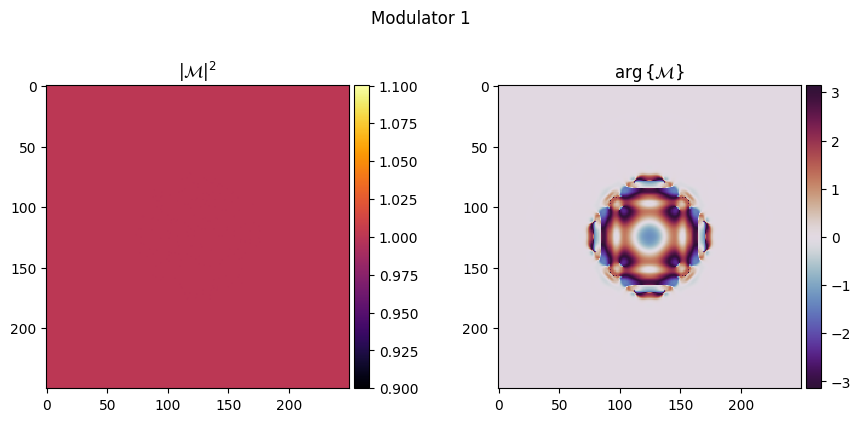

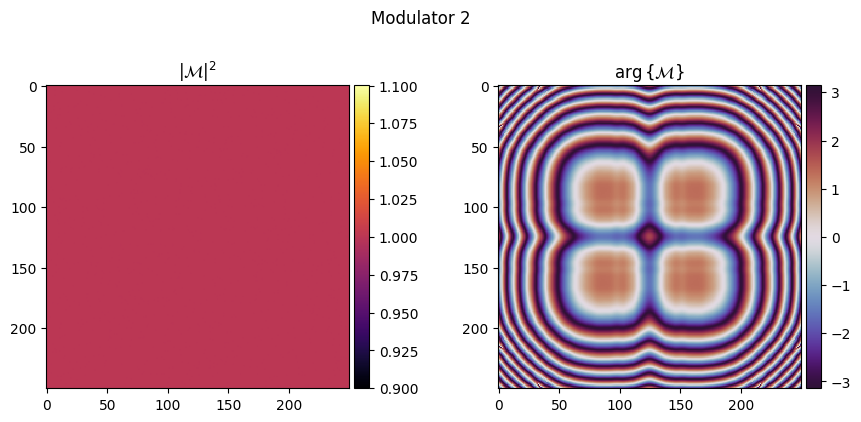

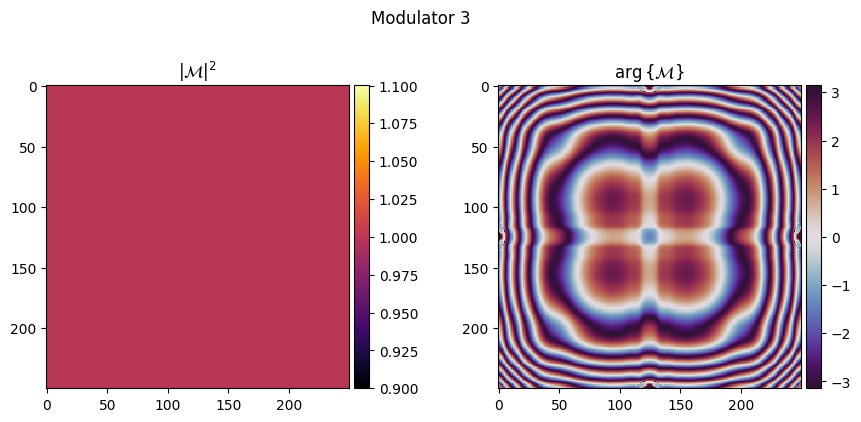

In [38]:
for i, element in enumerate(system):
    element.visualize(title=f"Modulator {i+1}")

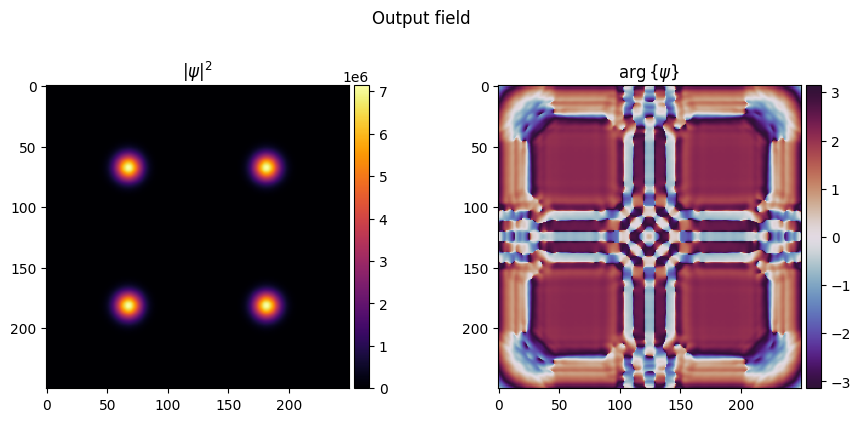

In [39]:
output_field = system.measure_at_z(input_field, 0.6)
output_field.visualize(title="Output field")

### Visualize diffraction patterns from three circular apertures
Code from Torch Optics tutorials

In [1]:
import torch
import torchoptics
import matplotlib.pyplot as plt

from torchoptics import Field, visualize_tensor
from torchoptics.profiles import circle

In [2]:
circle_shape = (800, 100)  # Number of grid points in each dimension
circle_radius = 200e-6  # Radius of each circle (m)
circle_separation = 2e-3  # Separation between the circles (m)

device = "cuda" if torch.cuda.is_available() else "cpu"

torchoptics.set_default_spacing(10e-6)
torchoptics.set_default_wavelength(700e-9)

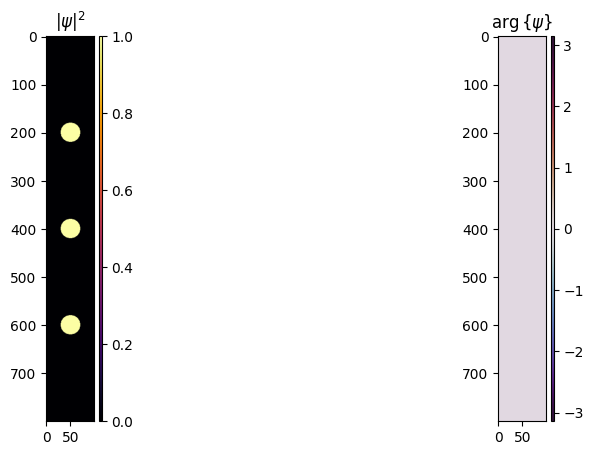

In [3]:
input_field = Field(
    circle(circle_shape, circle_radius, offset=(-circle_separation, 0))
    + circle(circle_shape, circle_radius, offset=(0, 0))
    + circle(circle_shape, circle_radius, offset=(circle_separation, 0))
)

input_field.visualize()

In [4]:
z_max = 2  # Maximum propagation distance (m)
z_num = 1000  # Number of propagation steps
propagation_shape = (800, 1)  # Number of grid points in each dimension

propagation_distances = torch.linspace(0, z_max, z_num)  # Propagation distances (m)
intensities = torch.zeros((z_num, propagation_shape[0]), device=device)  # Intensities at each z distance

In [5]:
# Propagate the input field through the propagation distances
for i, z in enumerate(propagation_distances):
    output_field = input_field.propagate(shape=propagation_shape, z=z)
    intensities[i] = output_field.intensity().flatten()  # Store the intensity

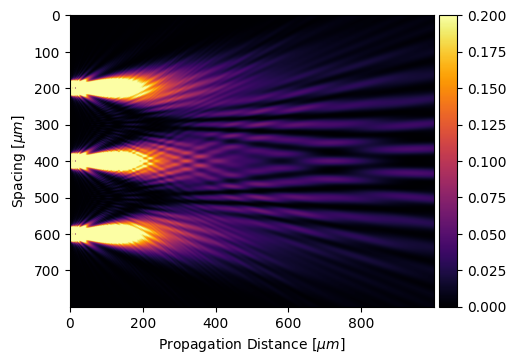

In [7]:
# Visualize the intensities at each propagation distance
visualize_tensor(intensities.T, xlabel="Propagation Distance [$\mu m$]", ylabel="Spacing [$\mu m$]", vmax=0.2)

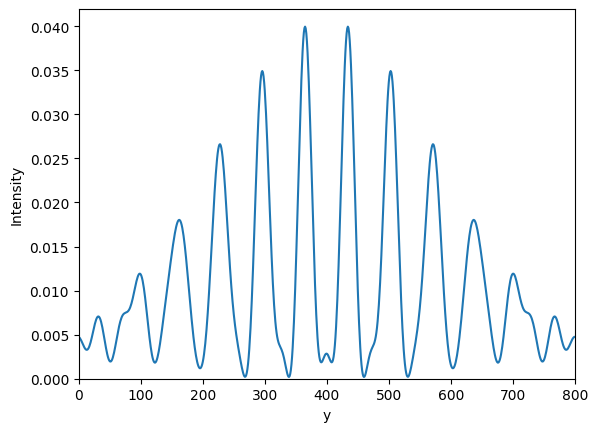

In [46]:
# Visualize the intensity at z_max
plt.plot(intensities[-1].cpu())
plt.xlabel("y")
plt.ylabel("Intensity")
plt.xlim(0, propagation_shape[0])
plt.ylim(0)
plt.show()